# Imports

In [1]:
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import matplotlib.pyplot as plt
from gym.envs.registration import register
import torch
from torch import nn
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [2]:
# Load data using yfinance
start_date = '2019-01-01'
end_date = '2022-01-01'
ticker = 'AAPL'  # Apple Inc.

# Fetch the data and select relevant columns
df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Calculate the date one year after the end date
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
one_year_later = end_date_dt + timedelta(days=362)  
one_year_later_str = one_year_later.strftime('%Y-%m-%d')

# Fetch data for the next year, to be used for evaluation
df_eval = yf.download(ticker, start=end_date, end=one_year_later_str)
df_eval = df_eval[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%%**********************]  1 of 1 completed


# Definition of environment

In [4]:
class CustomTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size=7, frame_bound=(0, None), transaction_cost=0.001):
        super(CustomTradingEnv, self).__init__()

        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound if frame_bound[1] else (frame_bound[0], len(df))

        self.current_step = 0
        self.transaction_cost = transaction_cost
        
        # Define action space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3) 
        
        # Scale the data
        self.data_scaled = self._scale_data()

        # Define observation space
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(df.shape[1], window_size), dtype=np.float16)

        # Reset the environment
        self.reset()

    def reset(self, seed=None, options=None):
        # Initialize the state variables
        self.current_step = self.frame_bound[0]
        self.done = False
        self.truncated = False
        self.position = 0  # 0: out, 1: long, -1: short
        self.total_profit = 0
        self.total_reward = 0
        self.trades = []
        obs = self._next_observation()
        return obs, {}

    def _scale_data(self):
        # Scale the data to the range [0, 1]
        df_scaled = self.df.copy()
        for column in df_scaled.columns:
            min_val = df_scaled[column].min()
            max_val = df_scaled[column].max()
            df_scaled[column] = (df_scaled[column] - min_val) / (max_val - min_val)
        return df_scaled

    def _next_observation(self):
        # Get the next observation frame
        start = self.current_step - self.window_size
        if start < 0:
            start = 0
        frame = self.data_scaled.iloc[start:self.current_step]
        if len(frame) < self.window_size:
            frame = frame.reindex(range(start, self.current_step)).fillna(0)
        return frame.values.astype(np.float32)

    def step(self, action):
        self.current_step += 1

        # Check if the episode is done
        if self.current_step >= self.frame_bound[1]:
            self.current_step = self.frame_bound[1] - 1
            self.done = True
            self.truncated = True
        else:
            self.done = False
            self.truncated = False

        # Get current and previous prices
        current_price = self.df.iloc[self.current_step, 3]  # Close price
        previous_price = self.df.iloc[self.current_step - 1, 3]  # Close price

        # Initialize reward
        reward = 0

        # Action logic
        if action == 1:  # Buy
            if self.position == -1:  # Closing short position
                reward += (previous_price - current_price) - self.transaction_cost * current_price
            self.position = 1  # Go long
        elif action == 2:  # Sell
            if self.position == 1:  # Closing long position
                reward += (current_price - previous_price) - self.transaction_cost * current_price
            self.position = -1  # Go short
        else:  # Hold
            if self.position == 1:  # Holding long position
                reward += current_price - previous_price
            elif self.position == -1:  # Holding short position
                reward += previous_price - current_price

        # Update total reward and profit
        self.total_reward += reward
        self.total_profit += reward

        # Log trade
        self.trades.append({
            'step': self.current_step,
            'action': action,
            'position': self.position,
            'reward': reward,
            'total_profit': self.total_profit
        })

        # Get the next observation
        obs = self._next_observation()

        return obs, reward, self.done, self.truncated, {}

    def render(self, mode='human', close=False):
        # Print the current step and profit
        profit = self.df.iloc[self.current_step, 3] - self.df.iloc[self.frame_bound[0], 3]
        print(f'Step: {self.current_step}, Profit: {profit}')

    def render_all(self):
        # Print all trades
        for trade in self.trades:
            print(trade)

    def sample_data(self):
        # Print sample observation data
        print("Sample Observation Data:")
        for i in range(5):
            self.current_step += 1
            print(self._next_observation())


In [5]:
# Register the custom trading environment
register(
    id='CustomTrading-v0',
    entry_point='__main__:CustomTradingEnv',
    max_episode_steps=2000,
)

# Create the trading environment
env = gym.make('CustomTrading-v0', df=df, window_size=7, frame_bound=(7, len(df)))

/Users/lars/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 7)
  logger.warn(


# Definine the agent

In [6]:
class AgentNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze=False):
        super().__init__()

        # LSTM layers
        self.lstm_hidden_size = 50
        self.lstm_layers = 2
        self.lstm = nn.LSTM(input_shape[1], self.lstm_hidden_size, num_layers=self.lstm_layers, batch_first=True)

        # Linear layers
        self.network = nn.Sequential(
            nn.Linear(self.lstm_hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        
        if freeze:
            self._freeze()
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last time step
        return self.network(lstm_out)

    def _freeze(self):
        for p in self.network.parameters():
            p.requires_grad = False


In [7]:
class Agent:
    def __init__(self, 
                 input_dims, 
                 num_actions, 
                 lr=0.00025, 
                 gamma=0.9, 
                 epsilon=1.0, 
                 eps_decay=0.999975, 
                 eps_min=0.1, 
                 replay_buffer_capacity=100_000, 
                 batch_size=32, 
                 sync_network_rate=10000):
        
        self.num_actions = num_actions
        self.learn_step_counter = 0

        # Hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.sync_network_rate = sync_network_rate

        # Networks
        self.online_network = AgentNN(input_dims, num_actions)
        self.target_network = AgentNN(input_dims, num_actions, freeze=True)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()

        # Replay buffer
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def choose_action(self, observation):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)

        # Convert observation to tensor and add batch dimension
        observation = torch.tensor(
            np.array(observation), dtype=torch.float32
        ).unsqueeze(0).to(self.online_network.device)

        # Ensuring the observation is in the correct shape (batch_size, seq_len, input_size)
        if len(observation.shape) == 2:
            observation = observation.unsqueeze(0)

        return self.online_network(observation).argmax().item()

    def decay_epsilon(self):
        # Decay epsilon value
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def store_in_memory(self, state, action, reward, next_state, done):
        # Store experience in replay buffer
        self.replay_buffer.add(TensorDict({
            "state": torch.tensor(np.array(state), dtype=torch.float32), 
            "action": torch.tensor(action),
            "reward": torch.tensor(reward), 
            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32), 
            "done": torch.tensor(done)
        }, batch_size=[]))
        
    def sync_networks(self):
        # Sync online and target networks
        if self.learn_step_counter % self.sync_network_rate == 0 and self.learn_step_counter > 0:
            self.target_network.load_state_dict(self.online_network.state_dict())
        
    def learn(self):
        # Learn from experiences in the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return

        self.sync_networks()

        self.optimizer.zero_grad()
        
        # Sample a batch of experiences from the replay buffer
        samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)

        keys = ("state", "action", "reward", "next_state", "done")
        states, actions, rewards, next_states, dones = [samples[key] for key in keys]

        # Ensuring the states and next_states are in the correct shape (batch_size, seq_len, input_size)
        if len(states.shape) == 3:
            states = states
        else:
            states = states.view(self.batch_size, -1, states.shape[-1])

        if len(next_states.shape) == 3:
            next_states = next_states
        else:
            next_states = next_states.view(self.batch_size, -1, next_states.shape[-1])
            
        # Compute predicted Q-values and target Q-values
        predicted_q_values = self.online_network(states)  
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        target_q_values = self.target_network(next_states).max(dim=1)[0]
        target_q_values = rewards + self.gamma * target_q_values * (1 - dones.float())
        
        # Compute loss and perform backpropagation
        loss = self.loss(predicted_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        self.decay_epsilon()


# Training

In [8]:
# Hyperparameters
NUM_OF_EPISODES = 500  
SHOULD_TRAIN = True  

input_dims = (7, 5)  
num_actions = 3  
agent = Agent(input_dims, num_actions)

In [10]:
# Lists for tracking metrics
average_rewards = []
episode_times = []
all_trades = []

for i in range(NUM_OF_EPISODES):
    print("Episode:", i)
    start_time = time.time()  # Record the start time of the episode
    done = False
    state, _ = env.reset()  # Reset the environment
    total_reward = 0
    steps = 0
    
    while not done:
        a = agent.choose_action(state)  # Agent selects an action
        new_state, reward, done, truncated, info = env.step(a)  # Environment responds to the action
        total_reward += reward  # Accumulate the reward

        if SHOULD_TRAIN:
            # Store experience in replay buffer and learn
            agent.store_in_memory(state, a, reward, new_state, done)
            agent.learn()

        state = new_state  # Move to the next state
        steps += 1

    end_time = time.time()  # Record the end time of the episode
    episode_times.append(end_time - start_time)  # Calculate and store episode duration
    average_rewards.append(total_reward / steps)  # Calculate and store average reward per step
    all_trades.append(env.trades)  # Store trades made during the episode

    print("Total reward:", total_reward, "Epsilon:", agent.epsilon)


Episode: 0
Total reward: -31.39806813430787 Epsilon: 0.9792676702916613
Episode: 1
Total reward: -47.331698600769 Epsilon: 0.9610772422811885
Episode: 2
Total reward: -29.98022821426394 Epsilon: 0.9432247113352703
Episode: 3
Total reward: -62.99681238555906 Epsilon: 0.9257038008326982
Episode: 4
Total reward: -120.29068295288083 Epsilon: 0.9085083507439062
Episode: 5
Total reward: -12.779276889801038 Epsilon: 0.8916323154652198
Episode: 6
Total reward: -1.3761101799011386 Epsilon: 0.8750697616933282
Episode: 7
Total reward: -127.63483892440793 Epsilon: 0.8588148663392482
Episode: 8
Total reward: -14.185872207641605 Epsilon: 0.8428619144810356
Episode: 9
Total reward: -56.77380994033815 Epsilon: 0.8272052973545155
Episode: 10
Total reward: -20.904787899017332 Epsilon: 0.8118395103813495
Episode: 11
Total reward: -46.83176531219482 Epsilon: 0.7967591512337316
Episode: 12
Total reward: -2.7073726463317964 Epsilon: 0.7819589179350198
Episode: 13
Total reward: 28.421315612792966 Epsilon: 0.

# Evaluation of Training

In [11]:
# Function to plot the moving average and the avg. reward for each episode
def plot_moving_avg(values, window):
    weights = np.repeat(1.0, window) / window
    smas = np.convolve(values, weights, 'valid')
    plt.plot(values, label='Average Reward per Episode', color='blue')
    plt.plot(range(window-1, len(values)), smas, label=f'Moving Average (window size={window})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Average Reward and Moving Average Reward')
    plt.legend()
    plt.show()

# Function to plot the agent's decisions
def plot_agent_decisions(trades, df):
    df = df.copy()
    df['Action'] = 0  # 0: Hold, 1: Buy, 2: Sell

    # Iterate through the trades and update the actions in the dataframe
    for trade in trades:
        step_index = df.index[trade['step']]
        if trade['action'] == 1:
            df.at[step_index, 'Action'] = 1  # Buy
        elif trade['action'] == 2:
            df.at[step_index, 'Action'] = -1  # Sell
        else:
            df.at[step_index, 'Action'] = 0  # Hold

    # Plot decisions
    plt.figure(figsize=(15, 6))
    plt.plot(df['Close'], label='Close Price')
    buy_signals = df[df['Action'] == 1]
    sell_signals = df[df['Action'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='o', color='g', label='Buy Signal', s=13)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='o', color='r', label='Sell Signal', s=13)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Agent Decisions')
    plt.legend()
    plt.show()


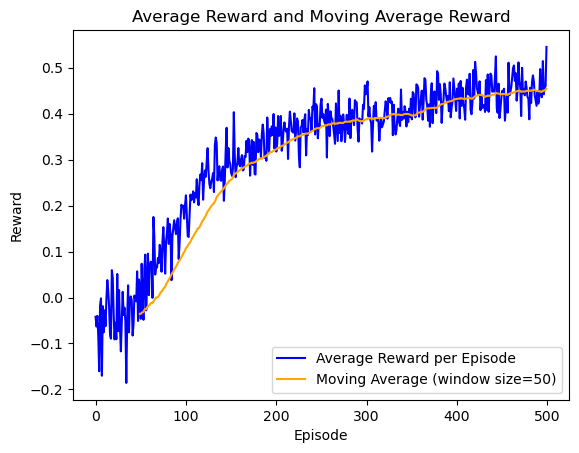

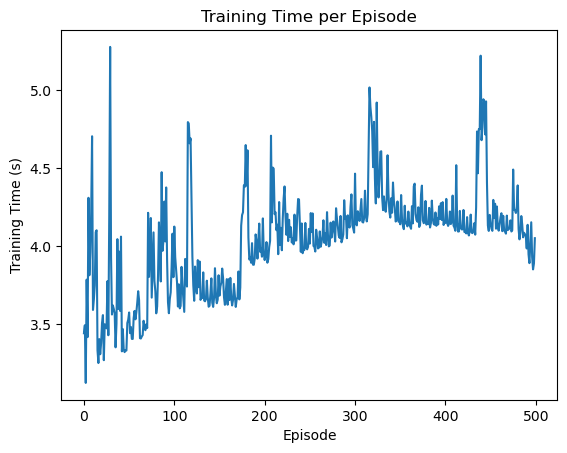

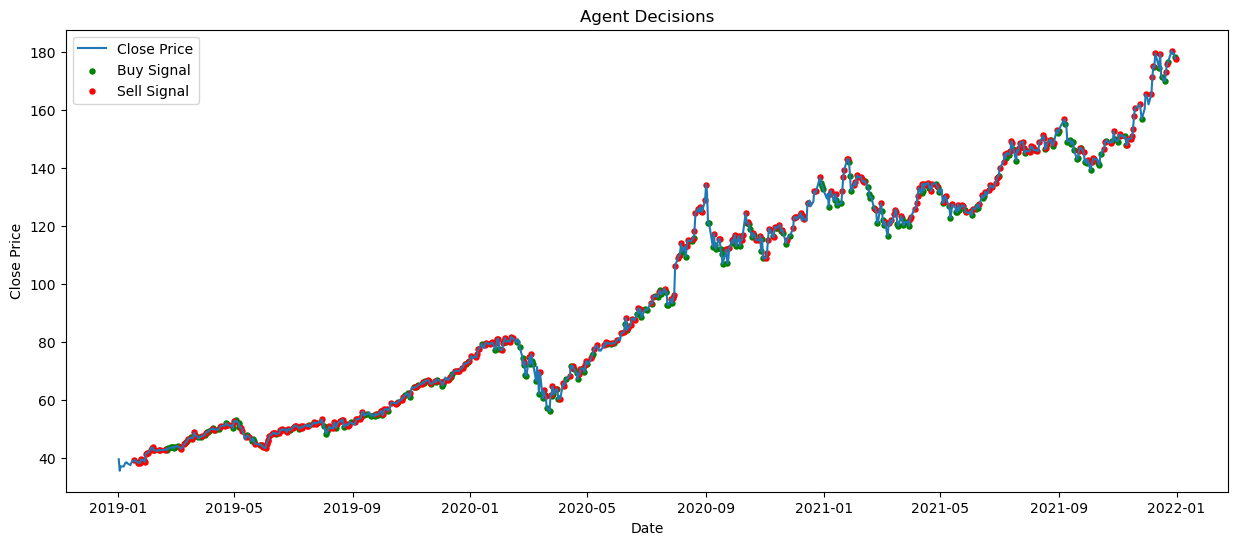

In [12]:
# Plot the reward
plot_moving_avg(average_rewards, window=50)

# Plot training time
plt.plot(episode_times)
plt.xlabel('Episode')
plt.ylabel('Training Time (s)')
plt.title('Training Time per Episode')
plt.show()

# Plot the decisions for the last episode
plot_agent_decisions(all_trades[-1], df)

# Testing

In [13]:
# Create the trading environment (evaluation)
evaluation_env = gym.make('CustomTrading-v0', df=df_eval, window_size=7, frame_bound=(7, len(df_eval)))

/Users/lars/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 7)
  logger.warn(


In [15]:
agent.epsilon = 0

# Variable to store the reward of the single evaluation episode
single_evaluation_reward = 0

all_evaluation_trades = []

# Execute a single evaluation episode
done = False
state, _ = evaluation_env.reset()  # Reset the evaluation environment
total_reward = 0
steps = 0

while not done:
    a = agent.choose_action(state) 
    new_state, reward, done, truncated, info = evaluation_env.step(a)  # Environment responds to the action
    total_reward += reward  
    state = new_state  # Move to the next state
    steps += 1  

single_evaluation_reward = total_reward / steps  # Average reward per step for this episode
all_evaluation_trades.append(evaluation_env.trades)

# Print or store the single evaluation reward
print(f"Single Evaluation Reward: {single_evaluation_reward}")


Single Evaluation Reward: 0.05896356573183669


In [16]:
# Function to plot the cumulative rewards(=profit) of one episode
def plot_cumulative_rewards(trades, df):
    df = df.copy()
    df['Reward'] = 0

    # Iterate through the trades and update the 'Reward' column in the dataframe
    for trade in trades:
        step_index = df.index[trade['step']]
        df.at[step_index, 'Reward'] = trade['reward']
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(df['Reward'].cumsum(), color='blue', label='Cumulative Reward')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Time')
    plt.legend()
    plt.show()


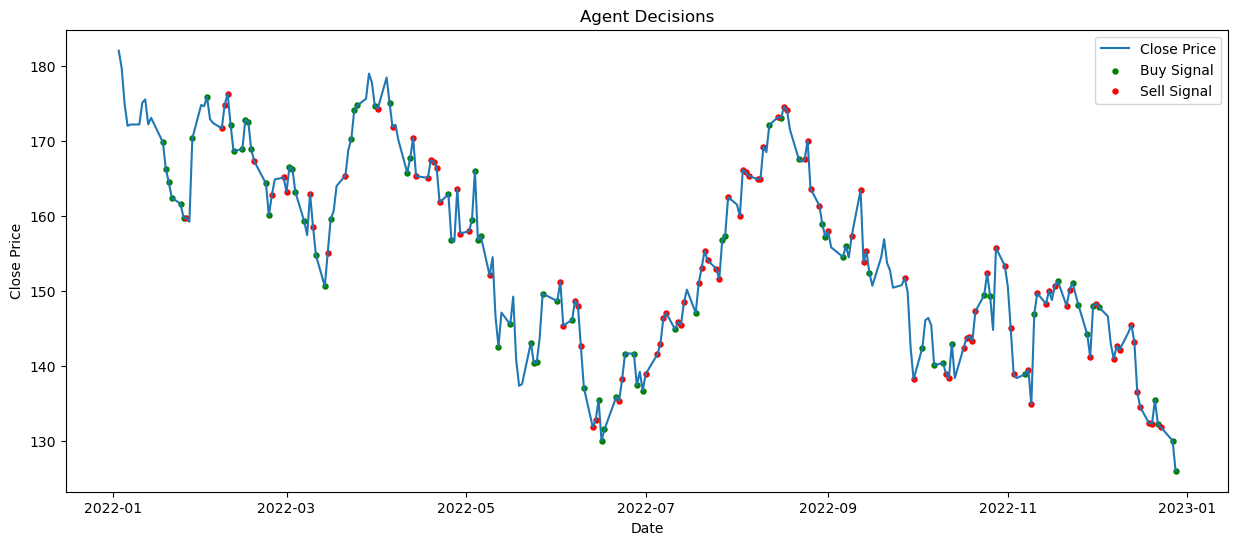

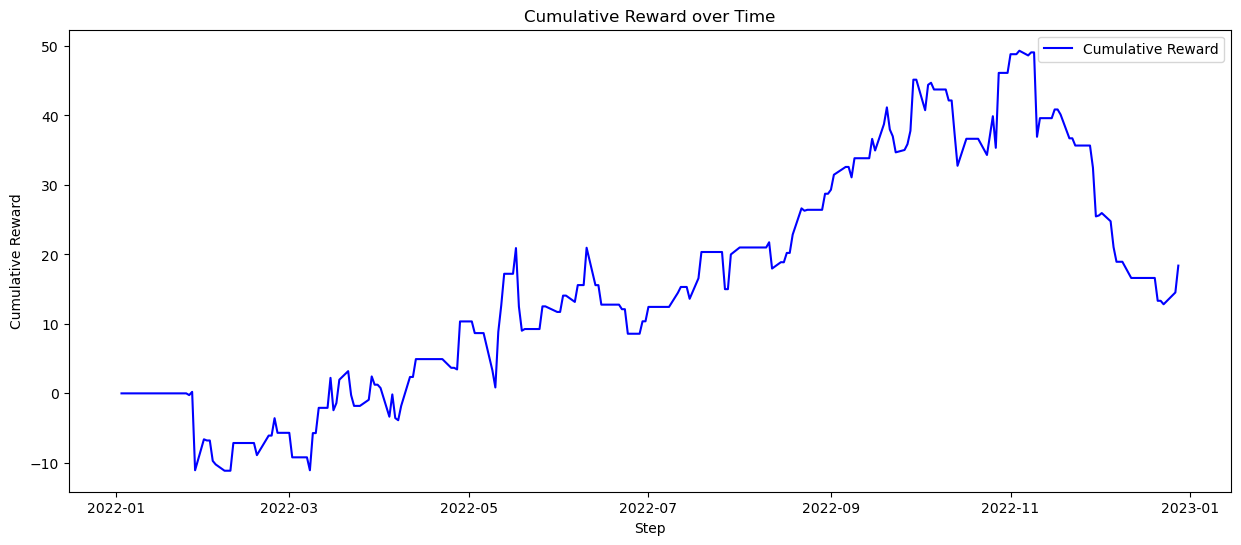

In [17]:
# Plot the decisions for the last evaluation episode
plot_agent_decisions(all_evaluation_trades[-1], df_eval)

# Plot the cumulative rewards for the last evaluation episode
plot_cumulative_rewards(all_evaluation_trades[-1], df_eval)